## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow().date()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(fit_intercept=False),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [6]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [7]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.

In [8]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
res = pd.read_csv(observed_confounding_error.experiment())



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[0.44817918]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')
identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### E

/home/amit/py-envs/env3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [66.01111446506712, 63.42171368715321, 64.22026514410959, 60.07327617273986, 66.11268277462945]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.4043452823078098, -0.3647962831615853, -2.21541790767271, -1.6785710619799894, -0.8455720357377832]
p_value [0.29273316903839963, 0.30148503109661196, 0.22187080612268173, 0.06603210218911704, 0.11437022710268163]
true value 0.44817917911950317


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.11210404],
       [ -0.32196533],
       [ -0.97871086],
       [ -1.26281336],
       [  0.68719986],
       [  0.75898286]]), 'confounder=>outcome': array([[100.24821178],
       [ -0.28815068],
       [  0.68388044],
       [  0.1686717 ],
       [ -0.45648749],
       [ -0.7459662 ]]), 'effe

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [79.31558790147682, 87.57423851525989, 83.22304007456479, 70.82305302519241, 80.4625567713151]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.5322719658492281, 0.960885295326101, -1.4600234515899306, 0.5834601976312914, 0.12621991081089856]
p_value [0.36372627736934315, 0.45671976543552667, 0.13256133161772277, 0.45366688903422736, 0.43520045202340896]
true value 1.6837945349991625


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.28597342],
       [ -1.52212317],
       [ -0.19623677],
       [  1.96504108],
       [ -1.97968276],
       [  0.39672758]]), 'confounder=>outcome': array([[ 9.96361438e+01],
       [ 1.24393684e-01],
       [ 1.96979689e+00],
       [ 1.06969767e+00],
       [ 2.72222271e-02],
       [-4.33041

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [56.8056700110375, 54.050289290217464, 55.5305537803361, 56.755396172182344, 55.89093866391693]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.7530933945870437, 1.2164053353150244, 2.7221944646172864, 0.7667922678529665, 1.789255529465299]
p_value [0.05303966888866703, 0.40964775241650786, 0.0761920855089611, 0.35561207079883494, 0.1351927934307971]
true value -0.03523687853074415


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.83447445],
       [-0.24647508],
       [ 0.50481799],
       [ 1.02181687],
       [ 1.46280972],
       [-0.26956647]]), 'confounder=>outcome': array([[100.25758113],
       [ -1.68874108],
       [ -1.90010531],
       [ -0.84530093],
       [ -1.39558635],
       [  1.5266641 ]]), 'effect_modifie

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [81.93034900607176, 74.72376193166004, 81.51913261914453, 90.76117347541982, 81.25397536273697]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.4762181099084522, -2.791117512625161, -1.5130157466790286, -0.04630618804938841, -0.0561524074193132]
p_value [0.49759964310721627, 0.13136395724079275, 0.05681104971830553, 1.8302581672458018e-09, 0.42552755817420496]
true value -0.8693562789260588


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.09074223],
       [ 0.7812276 ],
       [-0.73977197],
       [ 0.75498944],
       [-1.53178094],
       [-0.15781729]]), 'confounder=>outcome': array([[ 9.89612133e+01],
       [ 1.06649901e+00],
       [ 2.26681510e-01],
       [ 1.37951527e+00],
       [ 2.46759096e-01],
       [-5.56887

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [51.7108007036731, 42.44334638239872, 52.160815710330496, 50.348756827110684, 53.11978086678959]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.34653192524134296, -1.1133581946903768, -0.19685868900052556, 9.545866599925676e-17, 0.30708601216173564]
p_value [0.4782306690235113, 0.14613432984249952, 0.3639698263274844, 0.0, 0.4514963980819483]
true value -1.8606428030640734


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.87443866],
       [-0.18229819],
       [ 0.1304134 ],
       [ 0.61677473],
       [ 1.31832926],
       [-1.01926882]]), 'confounder=>outcome': array([[99.53206909],
       [ 0.53808285],
       [ 0.16009802],
       [-0.35480582],
       [ 0.40219817],
       [ 1.58191325]]), 'effect_modifier=>outcome': ar

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [49.94741405047206, 48.05887762242017, 49.616172187879464, 52.42870806313896, 49.39931177551444]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.7548020627227565, -2.1274544976816356, 0.19914776220930258, 0.43175883933601894, -0.5773724087133334]
p_value [0.3278918192078386, 0.24015791469893477, 0.4444909830516883, 0.4891359429643516, 0.36359178172779993]
true value -0.5345798400939739


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.24054824],
       [-0.31148549],
       [ 0.63418497],
       [-0.70302366],
       [-0.10838501],
       [-0.78371061]]), 'confounder=>outcome': array([[101.60203038],
       [ -0.43550855],
       [ -0.31282889],
       [  1.39256906],
       [ -2.70114908],
       [ -0.95938577]]), 'effect_mod

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [68.840209143251, 60.645168042668445, 69.07585782352533, 63.71187787956465, 68.72085690916778]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.2379854817365157, 8.900308318855485, 3.310839414536312, 0.5532392410523939, 8.668078002560508]
p_value [0.18757009248476014, 0.03223537337830508, 0.2936005583775579, 0.4725966416232196, 0.01410918095919035]
true value -0.6491817287366042


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.86670851e+01],
       [ 5.76664799e-01],
       [-8.80992636e-03],
       [ 3.06981530e-01],
       [ 5.38420134e-01],
       [ 6.57894030e-01]]), 'confounder=>outcome': array([[99.93242724],
       [-0.9484391 ],
       [-0.47857042],
       [ 2.28850605],
       [-0.43289329],
       [ 1.20978167]]), 

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [43.95562206111892, 40.98231894850907, 42.89244359861096, 42.21894095933778, 43.75677728056176]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-4.147565519505983, -1.7141140588235135, -1.7036157395761056, -0.7428775864227692, -2.1217000277206086]
p_value [0.013825076606160391, 0.2138210045430693, 0.08580012569262041, 0.1317513238252811, 0.03116820329055736]
true value -0.7118483425914773


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.93383371e+01],
       [-1.49190569e-01],
       [ 1.78021695e+00],
       [-7.28706319e-02],
       [ 8.17952509e-01],
       [ 1.37571741e+00]]), 'confounder=>outcome': array([[ 9.97984251e+01],
       [ 1.93083324e+00],
       [ 1.37314742e-01],
       [-3.80938219e-02],
       [ 3.14354014e-0

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [73.56220056774752, 75.72782687369617, 74.26061688517302, 68.65900244408805, 74.00602803590347]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.749647915200957, 1.8620034019388367, -1.356395307770431, -1.1753062441855366, -0.275904927572282]
p_value [0.36335761697581104, 0.24646307290506075, 0.22726845727933798, 0.13264628189994065, 0.39105436497147905]
true value -0.3937901793945747


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.36431219],
       [-1.35774824],
       [-0.33410297],
       [-0.37750026],
       [-1.42513053],
       [ 0.12266662]]), 'confounder=>outcome': array([[101.93716725],
       [ -0.52495031],
       [  1.387888  ],
       [ -0.77873453],
       [  0.52871309],
       [ -0.99022129]]), 'effect_modif

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [67.25415206544824, 65.29020071849979, 68.958392999682, 72.23278747313975, 67.01928297379473]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.08176920026248932, 2.752025043383573, 0.40789344015403, 0.8999260934353741, 0.6011498721748059]
p_value [0.44181950392725844, 0.2074635881108115, 0.4878406193539633, 0.3804854088033537, 0.48067500747317793]
true value 0.8331033725424504


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2021-03-02_data.csv


Co-variance matrix is undertermined. Inference will be invalid!


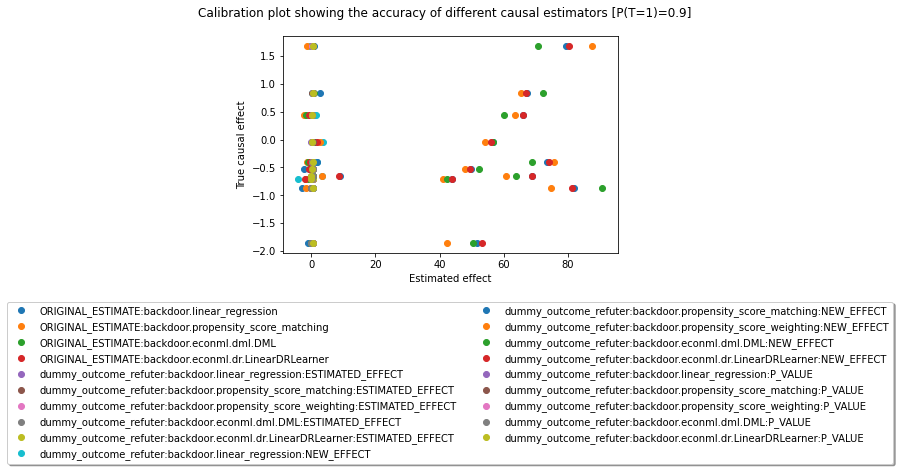

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 64.18317503790067
ORIGINAL_ESTIMATE:backdoor.linear_regression 64.14226789400405
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 63.010253145659064
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 61.50073009771594
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 2.177591843145904
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 2.0951190871186314
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 1.8776493671009689
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 1.7945621201670954
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.0123354779759617
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 1.0123354779759617
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_EFFECT 1.0123354779759617
dummy_outcome_refuter:backdoor.econml.dml.DML:ESTIMATED_EFFECT 1.0123354779759617
dumm

In [9]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [10]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

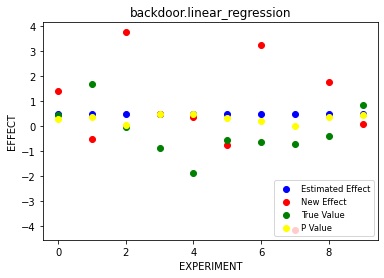

5.614951761166643


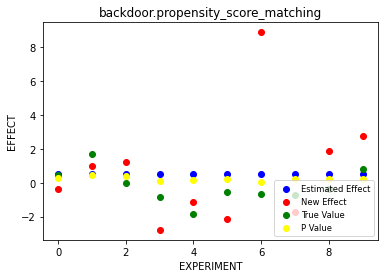

7.580786847836746


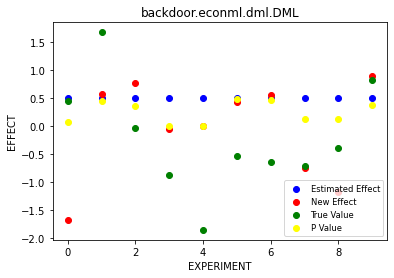

-0.40788444132963897


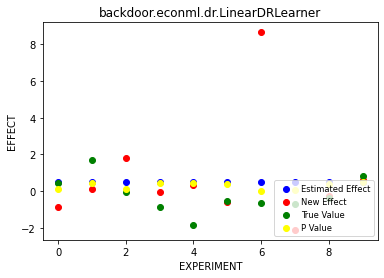

7.615087520009927


<Figure size 432x288 with 0 Axes>

In [11]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

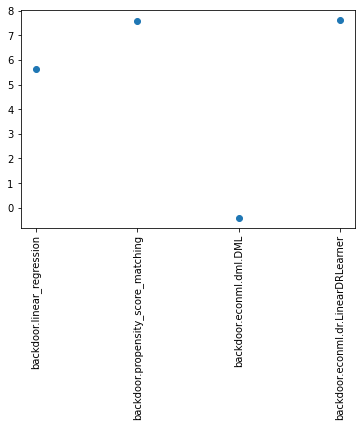

backdoor.linear_regression: 5.614951761166643
backdoor.propensity_score_matching: 7.580786847836746
backdoor.econml.dml.DML: -0.40788444132963897
backdoor.econml.dr.LinearDRLearner: 7.615087520009927


In [12]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [13]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


{'backdoor.econml.dr.LinearDRLearner': 7.615087520009927,
 'backdoor.propensity_score_matching': 7.580786847836746,
 'backdoor.linear_regression': 5.614951761166643,
 'backdoor.econml.dml.DML': -0.40788444132963897}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 

In [14]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='2',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
res = pd.read_csv(unobserved_confounding_error.experiment())



Running Experiment: Test_2


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[102.13812637],
       [ -2.14147323],
       [  0.74559931],
       [  1.82334284],
       [ -0.84180764],
       [ -0.43267877]]), 'confounder=>outcome': array([[98.84599708],
       [ 1.38527794],
       [ 1.28305666],
       [ 0.22955213],
       [ 0.87937314],
       [-1.60309691]]), 'effect_modifier=>outcome': array([[ 1.12255533],
       [-1.63556502]]), 'treatment=>outcome': array([[0.83310337]])}
        bias: {'confounder=>treatment': array([-0.63315655]), 'confounder=>outcome': array([-1.334491])}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing dat

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [79.73896673692579, 80.2231153857068, 81.441671077483, 74.14050297652312, 79.8135275952811]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824d9b9d00>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0     -1799.656139
1      1970.576405
2      -257.458589
3         9.207766
4     -3235.290458
          ...     
995    1894.515548
996     174.577874
997     151.620399
998   -216

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dc5a910>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0     -1799.914620
1      1969.601000
2      -255.491281
3         9.281650
4     -3234.971507
          ...     
995    1895.155143
996     174.262975
997     153.351989
998   -2170.867511
999    -590.528804
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dc511c0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [18.109527815435662, 22.06941753466051, 13.623703034488335, 5.100457293138294, 15.092567912044336]
p_value [0.029959562036282375, 0.11607794984112141, 0.038666604675627166, 0.2506163996915977, 0.09990571572586726]
true value -0.8830583669916872


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.32314608],
       [-0.83776679],
       [-1.50628162],
       [ 0.39118824],
       [ 2.00957198],
       [ 1.35123867]]), 'confounder=>outcome': array([[ 1.01149905e+02],
       [-2.32720298e-01],
       [ 3.18196048e-02],
       [-6.73120105e-01],
       [ 3.22509988e-01],
       [ 9.39482943e-02]

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.495324330578875, 57.46015746596635, 59.43111683011582, 49.29956832732684, 60.48473907812516]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0     -1800.415861
1      1970.400892
2      -256.214381
3         8.467135
4     -3235.720848
          ...     
995    1896.258364
996     172.804930
997     152.222951
998   -2172.207562
999    -589.254819
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dd88af0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})]

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824d9b96a0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0       719.299662
1     -2470.632087
2       315.994122
3       757.553815
4      2422.284233
          ...     
995     759.615956
996    -577.368395
997   -1621.337406
998    3012.924689
999   -1913.796841
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824da50550>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [6.94835455246095, 9.918842256509596, 2.357096749707265, 0.9805266955170486, 18.47709840831632]
p_value [0.1254228950600662, 0.13158690516860544, 0.3769484152178171, 0.4691191160773389, 0.11722193248225732]
true value -1.5223420102811438


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.06070786],
       [  0.15681475],
       [  1.53018757],
       [  0.54967092],
       [  0.49649097],
       [ -0.38317979]]), 'confounder=>outcome': array([[100.45289868],
       [  0.54782528],
       [  1.04031826],
       [  1.57859568],
       [  1.16346854],
       [ -2.31669068]]), 'effect_modifie

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [54.08827734735062, 48.57956472526583, 53.58722467427893, 53.452543289024554, 54.0847786381215]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0       717.356597
1     -2470.508920
2       314.035465
3       755.993326
4      2421.699178
          ...     
995     758.650179
996    -576.693323
997   -1622.027812
998    3013.669785
999   -1914.529562
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dd5e7f0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})],

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dc48d30>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0       296.896263
1      -160.915804
2       484.614813
3        57.882080
4       497.611633
          ...     
995   -1300.402970
996    1316.107986
997    -533.679544
998    -962.247195
999   -1918.423407
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dd51ee0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [10.482153968500835, 11.75166852518186, 6.355594773715404, 6.6598422259066155, -2.6448704408990595]
p_value [0.08543721931593112, 0.14426780340286505, 0.3126758252580647, 0.2674192834960121, 0.31750861729924695]
true value -0.01793005889331603


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.22735537],
       [ -0.38003344],
       [  0.51810224],
       [  1.48474532],
       [ -0.53379778],
       [ -0.93191245]]), 'confounder=>outcome': array([[100.07809133],
       [  1.40350686],
       [  0.15419506],
       [ -1.71495361],
       [  0.25148102],
       [ -1.27363351]]), 'effect_m

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [74.6949712584939, 74.21834719867091, 74.92414520819568, 64.8449507186782, 74.37524652709718]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0       297.530283
1      -160.364013
2       485.094503
3        56.636306
4       499.156317
          ...     
995   -1298.658070
996    1318.625869
997    -536.592489
998    -961.769918
999   -1919.585481
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dbcd730>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], '

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824c795f10>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      -796.522270
1       854.621285
2       937.587614
3       113.918901
4     -1935.810717
          ...     
995   -2149.353010
996    1039.090294
997     922.204273
998    -431.976665
999     413.689734
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824c6dd760>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [16.770556644348943, 11.250707511034431, 11.648851920215943, 7.958819670717124, 22.817904266584158]
p_value [0.055991375236347694, 0.19138089837534888, 0.10296379695709929, 0.23434594825334049, 3.502726752891062e-08]
true value -0.06104490497653794


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.57209214],
       [-0.89202431],
       [-0.85500288],
       [ 0.35472262],
       [-0.76661166],
       [ 0.38227932]]), 'confounder=>outcome': array([[101.75605264],
       [  2.26901297],
       [  1.1998282 ],
       [  0.6079511 ],
       [  0.21700173],
       [ -0.41042134]]), 'effect_mo

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [61.53479608240711, 59.06833738850809, 61.14309580696756, 49.2602874291804, 61.045369428308305]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      -796.816950
1       855.555357
2       938.950350
3       114.249044
4     -1934.939667
          ...     
995   -2147.384210
996    1038.210231
997     923.836633
998    -432.397171
999     414.569145
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824ddcb130>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})],

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824da72d60>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      2522.923719
1      -626.792015
2      -773.911414
3     -1327.512935
4      -320.616773
          ...     
995    1699.006229
996      98.832510
997    2069.392058
998     843.547467
999     168.386133
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824da5ca90>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [10.049791406120011, 7.2558831682937495, 5.223507582246741, -1.1404484066805178, 9.375079983128604]
p_value [0.04924138901624806, 0.23591014825100232, 0.28916340569847815, 0.41540550943043975, 0.14540869300115378]
true value -0.9358134414484054


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.54417722],
       [  1.31175017],
       [  0.24398158],
       [  0.18085462],
       [ -0.81233174],
       [  0.67159129]]), 'confounder=>outcome': array([[98.74365829],
       [-0.59263449],
       [ 0.5722103 ],
       [-1.44916037],
       [ 0.73335108],
       [-1.87955899]]), 'effect_modifi

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.16469119236292, 64.53514643002428, 65.05786321955922, 66.21909357126837, 65.19978631006086]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      2523.368621
1      -628.118626
2      -773.222293
3     -1325.024841
4      -320.897473
          ...     
995    1698.085915
996      96.388482
997    2068.838960
998     843.939477
999     166.632443
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824d8b46a0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})],

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824d995280>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      4279.328025
1     -1376.560934
2      -809.716802
3      1764.644858
4      1356.887336
          ...     
995    3871.803740
996     243.653944
997     149.840248
998    1732.193592
999    3132.586582
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dbdadf0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [10.213391882438867, 5.562431211822528, 1.404494467723996, -1.6688115687936693, -6.457629327755795]
p_value [0.018192201395425735, 0.325365711171716, 0.45825182128061615, 0.43774137089506804, 0.1874106481436102]
true value 1.510024807904736


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01691530e+02],
       [ 9.00885667e-01],
       [-2.56108938e-02],
       [-9.73911879e-01],
       [ 4.33855733e-01],
       [-4.26569048e-01]]), 'confounder=>outcome': array([[ 1.01275261e+02],
       [-1.05529021e+00],
       [-1.33066355e+00],
       [ 1.62965929e+00],
       [ 4.24984916e-02],
    

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [58.22962069722199, 51.46225484263082, 58.48922320058226, 46.406806114485434, 59.946918794668946]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      4279.889390
1     -1377.310919
2      -809.458286
3      1763.757330
4      1355.157608
          ...     
995    3872.839246
996     244.195668
997     151.245093
998    1733.060859
999    3130.900522
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dc538b0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824d9fcca0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      1089.848536
1     -1620.437080
2       275.138958
3      -513.787839
4      -434.995183
          ...     
995    1666.014656
996    2290.633884
997    1649.005843
998   -1204.961230
999   -1369.853746
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824db1ca00>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [6.304682313952377, -0.22962796589613657, 5.518016286964299, -6.276959644408334, 2.069195868709715]
p_value [0.044350854861726255, 0.46921763468762834, 0.1750318241922761, 0.2516510925083546, 0.4498483962519302]
true value -0.8579585829818099


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.67547167],
       [ 0.36401658],
       [ 0.83506901],
       [-0.83773006],
       [-0.67861709],
       [-1.23520126]]), 'confounder=>outcome': array([[100.99374346],
       [  2.38855639],
       [  0.54942851],
       [  0.8070533 ],
       [ -0.13323594],
       [  1.68965612]]), 'effect_modifier

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': Polynom

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [58.92514038942321, 55.090111633367655, 57.29472898265306, 42.408007566323604, 58.69924800511638]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      1090.741241
1     -1619.694308
2       274.513183
3      -512.477087
4      -435.068800
          ...     
995    1665.706028
996    2291.790649
997    1648.600484
998   -1203.908457
999   -1370.296571
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824db9aca0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824dc48670>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0     -1658.222437
1       940.647201
2      3018.136965
3      2564.464212
4      -833.097117
          ...     
995    -765.550026
996   -2048.795388
997   -3408.663804
998     180.852503
999   -1227.688163
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824da5b130>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [14.228727792959905, 7.056591290485088, 6.874851676379177, 5.548700302759351, 9.303339632017781]
p_value [0.00011146036336207591, 0.2785154809742681, 0.006835898411978253, 0.33768804423500587, 0.06892193202917955]
true value 1.5547046478266224


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[9.96195562e+01],
       [6.43144823e-01],
       [7.12264633e-02],
       [4.26179702e-01],
       [2.65429155e-01],
       [1.12591576e+00]]), 'confounder=>outcome': array([[98.60200789],
       [-1.32027236],
       [ 0.20083965],
       [-0.71647753],
       [ 0.67945411],
       [ 0.49955246]]), 'ef

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.04061810460664, 55.887152671633686, 60.2630397559419, 63.94518216554944, 60.14964474866858]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0     -1657.890677
1       938.913553
2      3016.282819
3      2565.006963
4      -830.049553
          ...     
995    -766.695571
996   -2050.319409
997   -3407.647069
998     182.584367
999   -1228.576131
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824c7c1a60>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})],

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824e86ac70>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      2708.156154
1        57.590849
2       -61.371660
3      1578.789778
4       585.516857
          ...     
995     932.065975
996    1433.260807
997   -1305.730022
998   -2865.404606
999     737.244418
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824ed03a30>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [9.761347084710797, 11.70372585950415, 12.653425027225603, 14.288185375347211, 0.10455221410212197]
p_value [0.09453926135230384, 0.07465124518673548, 0.09753320940496213, 0.045333644316214415, 0.4853745566037485]
true value -0.26377054845275383


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.99411229e+01],
       [-2.00754798e-02],
       [ 2.10369354e+00],
       [ 9.62460702e-02],
       [-1.95826174e+00],
       [-1.29671150e+00]]), 'confounder=>outcome': array([[ 1.00696550e+02],
       [ 9.03903506e-01],
       [ 7.36402377e-03],
       [-4.14383241e-01],
       [-8.37112978e-01],

Co-variance matrix is undertermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [63.08475520510219, 47.189872300307854, 62.05364801885312, 58.26771298615824, 62.761999618690794]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      2711.330533
1        57.203514
2       -63.307864
3      1577.051038
4       585.436448
          ...     
995     931.847281
996    1431.781880
997   -1305.110740
998   -2863.220660
999     735.761150
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824d93ba30>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f82c062b310>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f8253b014c0>, 'unobserved_confounder_values': 0      1519.189465
1       763.469809
2       -26.174460
3     -1823.912280
4       897.942334
          ...     
995     484.547509
996    -861.288079
997   -1271.476650
998   -2507.297576
999   -1061.146403
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f824c7eaaf0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!
Co-variance matrix is undertermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.030353284233114942, 5.674258575539097, 6.799848808518449, 0.5540804945527011, 2.6922710300409918]
p_value [0.478452422877625, 0.30293858186884604, 0.2573908986876245, 0.4805385362558892, 0.3880755671655681]
true value 0.7256263127405129


Completed all experiments. Saving the data...
Data has been saved in  results/Test_2_2021-03-02_data.csv


Co-variance matrix is undertermined. Inference will be invalid!


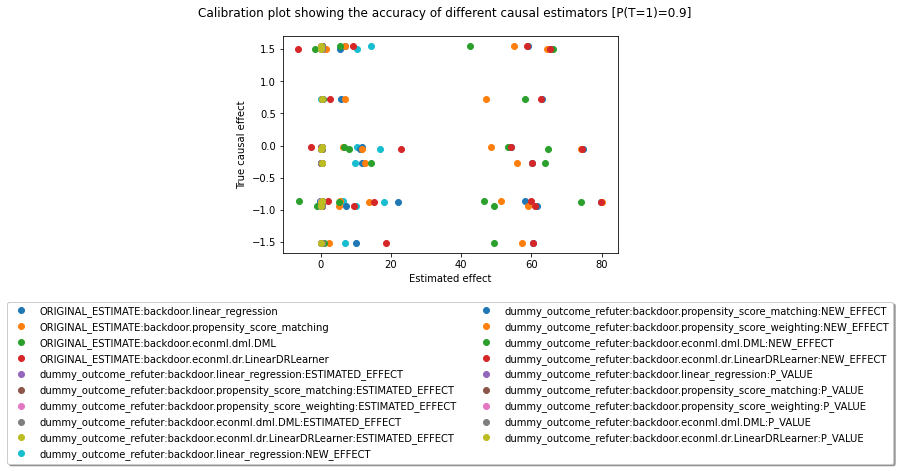

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 63.73128208896926
ORIGINAL_ESTIMATE:backdoor.linear_regression 63.674872349002705
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 59.44656221876361
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 56.899621729007194
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 10.504099494773005
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 9.27702607271755
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 9.276546011268865
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 7.342201315310048
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 5.070399102669931
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.0332273682497526
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 1.0332273682497526
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_EFFECT 1.0332273682497526
dummy_outcome

In [15]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

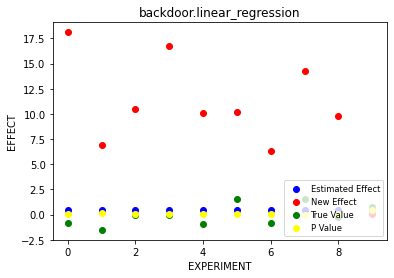

102.89888674516146


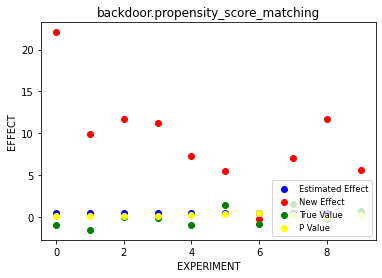

92.01389796713487


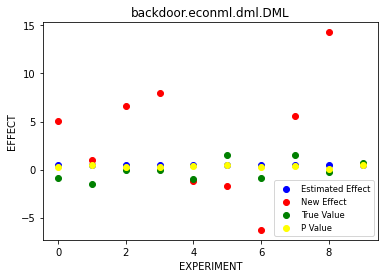

32.004392438055824


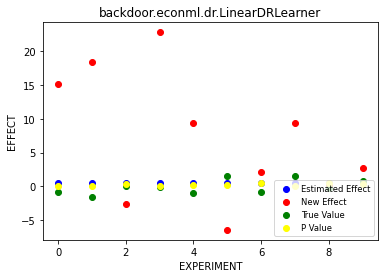

70.82950954628919


<Figure size 432x288 with 0 Axes>

In [16]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

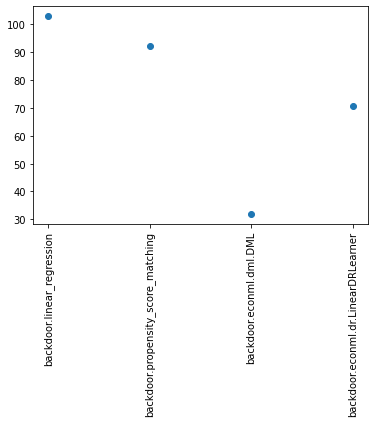

backdoor.linear_regression: 102.89888674516146
backdoor.propensity_score_matching: 92.01389796713487
backdoor.econml.dml.DML: 32.004392438055824
backdoor.econml.dr.LinearDRLearner: 70.82950954628919


In [17]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [18]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

{'backdoor.linear_regression': 102.89888674516146,
 'backdoor.propensity_score_matching': 92.01389796713487,
 'backdoor.econml.dr.LinearDRLearner': 70.82950954628919,
 'backdoor.econml.dml.DML': 32.004392438055824}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML
2. Linear DR Learner 
3. Propensity Score Matching
4. Linear Regression

#### We can see that this ranking produces the same top-ranked estimator as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a close-to-correct ranking amongst methods.